In [ ]:
# coding: utf-8
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [5]:
# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

In [6]:
# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
std=0.01:2.3025327264278674
Xavier:2.2983248825206206
He:2.2764794967681783
===========iteration:100===========
std=0.01:2.302451671448555
Xavier:2.233141388601135
He:1.3927678985481537
===========iteration:200===========
std=0.01:2.304235593775452
Xavier:2.095269960438142
He:0.7398126520200294
===========iteration:300===========
std=0.01:2.3018016172733784
Xavier:1.7660843946686207
He:0.5442761038513289
===========iteration:400===========
std=0.01:2.3028685754368965
Xavier:1.2090147428058742
He:0.49445993150364587
===========iteration:500===========
std=0.01:2.3007556485804863
Xavier:0.7748801778139064
He:0.3479903374430629
===========iteration:600===========
std=0.01:2.3012055570166647
Xavier:0.5976843385252251
He:0.2921575997954376
===========iteration:700===========
std=0.01:2.3040198676498522
Xavier:0.5816106353492524
He:0.39205531420150874
===========iteration:800===========
std=0.01:2.303783663191618
Xavier:0.4569041244985276
He:0.29608652080832

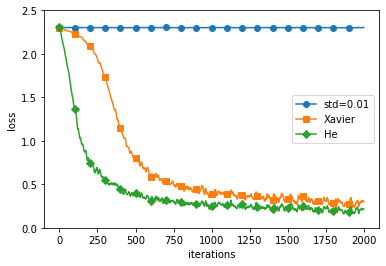

In [7]:
# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### Xavier 초기화

In [ ]:
# TensorFlow
tf.keras.initializers.GlorotNormal()

# PyTorch
torch.nn.init.xavier_normal_()

### He 초기화

In [ ]:
# TensorFlow
tf.keras.initializers.HeNormal()

# PyTorch
torch.nn.init.kaiming_normal_()

참고 URL : https://yngie-c.github.io/deep%20learning/2020/03/17/parameter_init/

### 배치정규화의 효과

============== 1/16 ==============
epoch:0 | 0.097 - 0.074
d:\남정재\문서\NAMRMINO\2021\빅딥_BigDeep\[밑바닥시리즈] 밑바닥부터 시작하는 딥러닝_1\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
d:\남정재\문서\NAMRMINO\2021\빅딥_BigDeep\[밑바닥시리즈] 밑바닥부터 시작하는 딥러닝_1\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
epoch:1 | 0.097 - 0.081
epoch:2 | 0.097 - 0.109
epoch:3 | 0.097 - 0.128
epoch:4 | 0.097 - 0.148
epoch:5 | 0.097 - 0.159
epoch:6 | 0.097 - 0.187
epoch:7 | 0.097 - 0.203
epoch:8 | 0.097 - 0.225
epoch:9 | 0.097 - 0.259
epoch:10 | 0.097 - 0.272
epoch:11 | 0.097 - 0.291
epoch:12 | 0.097 - 0.317
epoch:13 | 0.097 - 0.323
epoch:14 | 0.097 - 0.342
epoch:15 | 0.097 - 0.367
epoch:16 | 0.097 - 0.38
epoch:17 | 0.097 - 0.389
epoch:18 | 0.097 - 0.401
No handles with labels found to put in legend.
epoch:19 | 0.097 - 0.

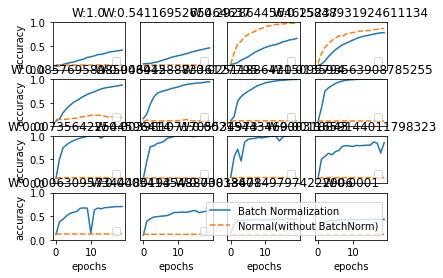

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

### 오버피팅

epoch:0, train acc:0.09333333333333334, test acc:0.091
epoch:1, train acc:0.11333333333333333, test acc:0.1114
epoch:2, train acc:0.14333333333333334, test acc:0.1246
epoch:3, train acc:0.16, test acc:0.1416
epoch:4, train acc:0.2, test acc:0.1566
epoch:5, train acc:0.23, test acc:0.1824
epoch:6, train acc:0.25666666666666665, test acc:0.2021
epoch:7, train acc:0.29, test acc:0.2132
epoch:8, train acc:0.31333333333333335, test acc:0.2265
epoch:9, train acc:0.3333333333333333, test acc:0.2314
epoch:10, train acc:0.31333333333333335, test acc:0.2326
epoch:11, train acc:0.37333333333333335, test acc:0.2541
epoch:12, train acc:0.3933333333333333, test acc:0.2725
epoch:13, train acc:0.38666666666666666, test acc:0.2781
epoch:14, train acc:0.4166666666666667, test acc:0.2908
epoch:15, train acc:0.4, test acc:0.2867
epoch:16, train acc:0.4266666666666667, test acc:0.3116
epoch:17, train acc:0.4266666666666667, test acc:0.3163
epoch:18, train acc:0.4066666666666667, test acc:0.3151
epoch:19, t

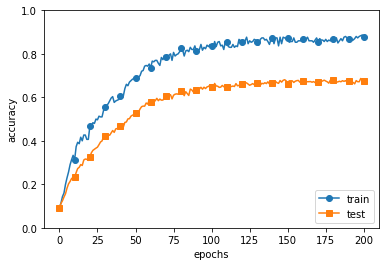

In [5]:
import os
import sys

sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay(가중치 감쇠) 설정 =============
# weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ===========================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 그래프 그리기 ================
markers = {'train':'o', 'test':'s'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 드롭아웃 (Drop-Out)

In [7]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

### MNIST 데이터셋으로 드롭아웃 효과 구현

4 ===
train loss:1.858516027863803
train loss:1.768728466006927
train loss:1.7633387300855454
=== epoch:169, train acc:0.4266666666666667, test acc:0.3648 ===
train loss:1.8500667393335772
train loss:1.8270960885892487
train loss:1.858764697513015
=== epoch:170, train acc:0.42, test acc:0.3663 ===
train loss:1.805793149570198
train loss:1.8527408939739614
train loss:1.7509267897616037
=== epoch:171, train acc:0.43666666666666665, test acc:0.3679 ===
train loss:1.8124306456597248
train loss:1.8664387131220075
train loss:1.7788438679241687
=== epoch:172, train acc:0.42333333333333334, test acc:0.3667 ===
train loss:1.7662910762953266
train loss:1.7294290481085082
train loss:1.8162774639338195
=== epoch:173, train acc:0.42333333333333334, test acc:0.3684 ===
train loss:1.7592797626201326
train loss:1.735085511792186
train loss:1.8797269936430467
=== epoch:174, train acc:0.4166666666666667, test acc:0.3654 ===
train loss:1.7217179140577645
train loss:1.781030795290813
train loss:1.75397243

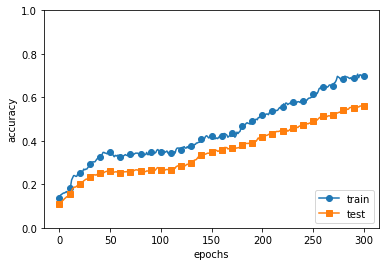

In [6]:
# coding : utf-8

import os
import sys
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_trian, t_trian), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비율 설정 ===========
use_dropout = True # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ========================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)

trainer = Trainer(network, x_train, t_train, x_test, t_test, epochs=301, mini_batch_size=100, optimizer='sgd', optimizer_param={'lr':0.01}, verbose=True)

trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기 ============
markers = {'train':'o', 'test':'s'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0,1,0)
plt.legend(loc='lower right')
plt.show()

### 검증데이터 (Validation Dataset)

In [12]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 하이퍼 파라미터 최적화 구현

In [18]:
# coding : utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_trian, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과물을 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_trian[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

def __train(lr, weight_decay, epochs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10, weight_decay_lambda=weight_decay)

    trainer = Trainer(network, x_train, t_train, x_val, t_val, epochs=epochs, mini_batch_size=100, optimizer='sgd', optimizer_param={'lr':lr}, verbose=False)

    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색 ===================
optimization_trial = 100
results_val = {}
results_train = {}

for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정 ==============
    weight_decay = 10 ** np.random.uniform(-8,-4)
    lr = 10 ** np.random.uniform(-6,-2)
    # ==============================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print ("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기 =============================
print("====== Hyper-Parameter Optimization Result =======")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(result_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)
    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5 : plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i>=graph_draw_num:
        break

plt.show()

val acc:0.1 | lr:4.893840046588351e-05, weight decay:1.4309431081699968e-06
val acc:0.05 | lr:6.896458967923043e-06, weight decay:7.516670721853873e-08
val acc:0.17 | lr:1.1772586328021747e-05, weight decay:2.2846326213111683e-06
val acc:0.1 | lr:6.295987230825859e-06, weight decay:2.9788697513927135e-08
val acc:0.05 | lr:2.1338365760692883e-05, weight decay:6.234090865747497e-08
val acc:0.68 | lr:0.006733833685422447, weight decay:2.0375988037967186e-08
val acc:0.06 | lr:0.00029492382317220726, weight decay:1.2749117247138427e-07
val acc:0.09 | lr:2.6575730133151288e-05, weight decay:1.5230073810128706e-08
val acc:0.13 | lr:3.2514370904203083e-06, weight decay:2.8408775079522916e-05
val acc:0.14 | lr:4.4650525305484835e-05, weight decay:2.1908016021072294e-05
val acc:0.13 | lr:1.5610194840249234e-06, weight decay:6.217240198017677e-07
val acc:0.09 | lr:2.7036965617841715e-05, weight decay:9.160503790389716e-06
val acc:0.77 | lr:0.008798710603746127, weight decay:7.074090068576012e-05
